# Surface Mass Balance: XGB 

Import relevant Libaries 

In [1]:
%pip install pyarrow
%pip install plotly
%pip install feature_engine
%pip update pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "update"
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats

# Visualizations
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns

# Set WD
import os
from pyrsistent import v
os.getcwd()

'/Users/nilsfulde/Desktop/Master_Thesis/scripts'

#### Load KAN_L 

In [35]:
#df = pd.read_csv(r'..\data\promice\preprocessed\daily\KAN_L.csv', index_col=0)
df = pd.read_csv(r'../data/promice/preprocessed/daily/KAN_L.csv', index_col=0)

#### Load SCO_L 

In [3]:
#df = pd.read_csv(r'..\data\promice\preprocessed\daily\KAN_L.csv', index_col=0)
df_1 = pd.read_csv(r'../data/promice/preprocessed/daily/KAN_L.csv', index_col=0)

df = df.append(df_1)

/var/folders/_r/2f7t_cz14232jqp3576_p04m0000gn/T/ipykernel_13608/2146712351.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_1)


##### Pre-processing (0.1: Change months to cycle)

In [36]:
# This bit to change the datetime variables into a form that a ML models can understand
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html
    
    
# This bit to split Datetime column into year, month, day, hour columns
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Datetime'] = df['Datetime'].dt.strftime('%Y-%m-%d')

df['Datetime'] = pd.to_datetime(df['Datetime'])

#Create new columns
#df['year'] = df['Datetime'].dt.year 
df['month'] = df['Datetime'].dt.month
#df['day'] = df['Datetime'].dt.day
#df['hour'] = df['Datetime'].dt.hour

#Drop the datetime column
df.drop(columns=['Datetime'], inplace=True)

In [37]:
# This bit to change the datetime variables into a form that a ML models can understand (continued)
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html 

# Use CyclicalFeatures Package to convert year, month, day & hour
from feature_engine.creation import CyclicalFeatures

cyclical = CyclicalFeatures(variables=None, drop_original=True)

# with year
#cyclical = cyclical.fit_transform(df[['month', 'year', 'Wind from direction (upper boom)']]) 

# Remove only values from Wind direction because CyclicalFeatures does not work with NAN
df = df[df['Wind from direction (upper boom)'].notna()] 

# without year
#cyclical = cyclical.fit_transform(df[['month', 'Wind from direction (upper boom)']]) 
cyclical = cyclical.fit_transform(df[['Wind from direction (upper boom)']]) 
df = pd.merge(df, cyclical, left_index=True, right_index=True)

df.drop(columns=['month', 'Wind from direction (upper boom)'], inplace=True)

##### Pre-processing (1.0: Filter relevant periods)

In [38]:
# Fill NA values in Melting season as blank
df['Melting Season'] = df['Melting Season'].fillna('no_ablation')

In [39]:
#Only Ablation Period Or Melting Season
df = df[df['Ablation'] == True]
#df =  df[df['Melting Season'].isin(['pre', 'beginning', 'middle', 'end'])]

#Remove all NA values if training should be done only on ablation
#df = df.dropna()

df = df.reset_index(drop=True)

In [40]:
# This bit retrieve the indexes for all melting season categories and remove column from df
for category in ['no_ablation', 'pre', 'beginning', 'middle', 'end']:
    exec(f"indices_{category} = df[df['Melting Season'] == '{category}'].index")

# This bit retrieve the indexes for Ablation periods
for category in [True]:
    exec(f"indices_ablation = df[df['Ablation'] == {category}].index")

indices_all = df[df['Ablation'].isin([True, False])].index

##### Pre-processing (2.0: Formatting and transformation)

In [41]:
from sklearn.preprocessing import LabelEncoder
 
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
df['Melting Season'] = le.fit_transform(df['Melting Season'])
label_dict = dict(zip(le.classes_, le.transform(le.classes_)))

class_order = ['no_ablation', 'pre', 'beginning', 'middle', 'end']

# Sort the label_dict based on the desired order of class names
label_dict_sorted = {class_name: label_dict[class_name] for class_name in class_order if class_name in label_dict}

In [42]:
# This bit to include only relevant features
exclude_list = [                                                    'index', # excluded because of unimportant information
                                                                     'stid', # excluded because of unimportant information
                                                               'Unnamed: 0', # Old Index
                                                                 'Ablation',
                                                          # 'Melting Season', # We drop melting season later 
                                              'year', 'month','day', 'hour', # Drop because of sin & cos values
                                                                 'subgroup',
                'Surface height from combined measurements',
                'Surface height from combined measurements DELTA'
               ]

df = df[[column for column in df.columns if column not in exclude_list]]


In [43]:
# This bit to convert all numerical values into the same scale 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]

# with year
#num_cols = df.select_dtypes(include=['int64','float64']).drop(['Surface height from combined measurements', 'Surface height from combined measurements DELTA','month_sin','month_cos','year_sin','year_cos','Wind from direction (upper boom)_sin', 'Wind from direction (upper boom)_cos', 'Melting Season'], axis=1).columns #select numerical columns except y and cyclical feature

# without year
#num_cols = df.select_dtypes(include=['int64','float64']).drop(['month_sin','month_cos','Wind from direction (upper boom)_sin', 'Wind from direction (upper boom)_cos', 'Melting Season'], axis=1).columns #select numerical columns except y and cyclical feature
num_cols = df.select_dtypes(include=['int64','float64']).drop(['Wind from direction (upper boom)_sin', 'Wind from direction (upper boom)_cos', 'Melting Season'], axis=1).columns #select numerical columns except y and cyclical feature

scaler = MinMaxScaler()

#fit and transform numerical columns
df[num_cols] = scaler.fit_transform(df[num_cols])

In [44]:
# This bit to split into Train & Test
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# split the data into training and testing sets while maintaining the subgroup distribution
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in split.split(df, df['Melting Season']):
    train = df.loc[train_index]
    test = df.loc[test_index]

# separate the features and target variables for the train and test sets
X_train = train.drop(['Melting Season'], axis=1)
y_train = train['Melting Season']
X_test = test.drop(['Melting Season'], axis=1)
y_test = test['Melting Season']



## XGB Classifier

In [45]:
# Import required libraries
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [46]:
# This bit to find best XBG Regressor model for when Ablation == True and for both target variables

indices = eval(f"indices_all")  # Get the indices for the current category

# Find common indexes
X_Train_valid_indices = indices.intersection(X_train.index)
y_Train_valid_indices = indices.intersection(y_train.index)
X_Test_valid_indices = indices.intersection(X_test.index)
y_Test_valid_indices = indices.intersection(y_test.index)

# filter out by indeces
X_train = X_train.loc[X_Train_valid_indices]  
y_train = y_train.loc[y_Train_valid_indices] 
X_test  = X_test.loc[X_Test_valid_indices]  
y_test  = y_test.loc[y_Test_valid_indices]

num_classes = y_test.unique().sum()

# Define the XGBClassifier model
model = xgb.XGBClassifier(objective='multi:softmax', num_class= num_classes)

# Define the hyperparameter grid for tuning
param_grid = {
    'max_depth': [ 5],
    'learning_rate': [0.001],
    'n_estimators': [100],
    'min_child_weight': [5],
    'gamma': [ 0],
}

# Define the grid search object
grid_search = GridSearchCV(model, param_grid = param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding accuracy score on the test set
print("Best hyperparameters: ", grid_search.best_params_)
y_pred = grid_search.predict(X_test)
print("Accuracy score on test set: ", accuracy_score(y_test, y_pred))
print("F1 score on test set: ", f1_score(y_test, y_pred, average='weighted'))

labels = [k for k, v in sorted(label_dict.items(), key=lambda item: item[1])]
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
print("Confusion matrix on test set: ")
print(cm_df)


# Save the best model parameters as 'model' variable
model = grid_search.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters:  {'gamma': 0, 'learning_rate': 0.001, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100}
Accuracy score on test set:  0.7987152034261242
F1 score on test set:  0.7886008068002457
Confusion matrix on test set: 
           beginning  end  middle
beginning         31    0      42
end                0   53      19
middle            13   20     289


In [47]:
for category, class_label in label_dict.items():
    indices = eval(f"indices_{category}")  # Get the indices for the current category

    # Find common indexes
    X_Train_valid_indices = indices.intersection(X_train.index)
    y_Train_valid_indices = indices.intersection(y_train.index)
    X_Test_valid_indices = indices.intersection(X_test.index)
    y_Test_valid_indices = indices.intersection(y_test.index)

    # filter out by indeces
    X_train_category = X_train.loc[X_Train_valid_indices]
    y_train_category = y_train.loc[y_Train_valid_indices]
    X_test_category = X_test.loc[X_Test_valid_indices]
    y_test_category = y_test.loc[y_Test_valid_indices]

    # Apply XGB on all periods  
    y_pred_category = model.predict(X_test_category)
    
    exec(f"accuracy_{category} = accuracy_score(y_test_category, y_pred_category)")
    exec(f"f1_{category} = f1_score(y_test_category, y_pred_category, average='weighted')")

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


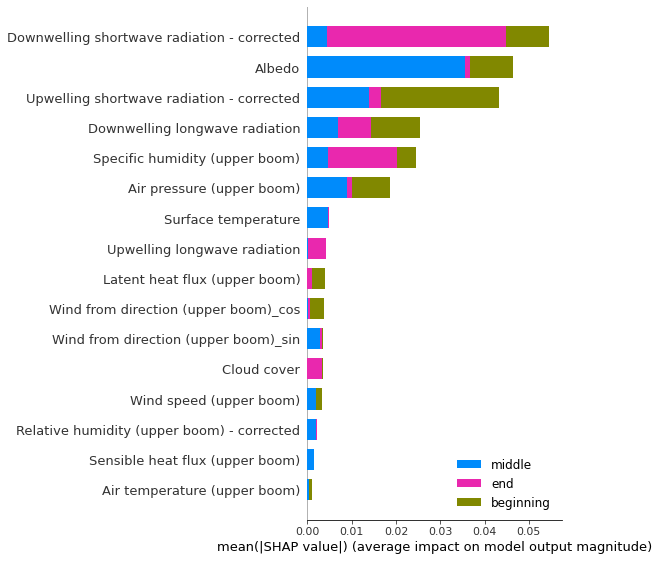

In [48]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test,approximate=True)
shap.summary_plot(shap_values, X_test, plot_type='bar', class_names=list(label_dict.keys()))

## Filter by Melting Season

In [61]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test)

beginning:
Accuracy: 0.4246575342465753
F1: 0.5961538461538461


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


,Feature,SHAP Value
0,Upwelling shortwave radiation - corrected,0.023399
1,Downwelling shortwave radiation - corrected,0.012321
2,Downwelling longwave radiation,0.012298
3,Air pressure (upper boom),0.008669
4,Albedo,0.008320


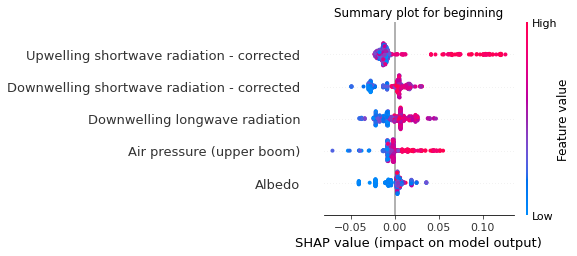

middle:
Accuracy: 0.8975155279503105
F1: 0.9459901800327332


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


,Feature,SHAP Value
0,Albedo,0.029871
1,Upwelling shortwave radiation - corrected,0.013706
2,Specific humidity (upper boom),0.007751
3,Downwelling longwave radiation,0.006902
4,Air pressure (upper boom),0.006484


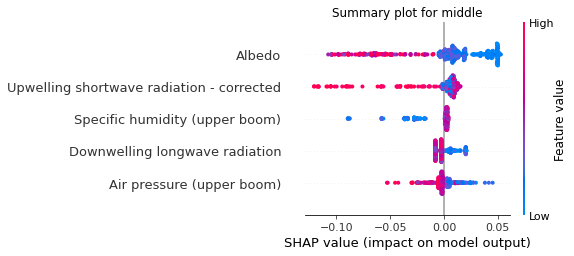

end:
Accuracy: 0.7361111111111112
F1: 0.8480000000000001


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


,Feature,SHAP Value
0,Downwelling shortwave radiation - corrected,0.040937
1,Specific humidity (upper boom),0.012861
2,Upwelling longwave radiation,0.005941
3,Downwelling longwave radiation,0.004980
4,Upwelling shortwave radiation - corrected,0.003875


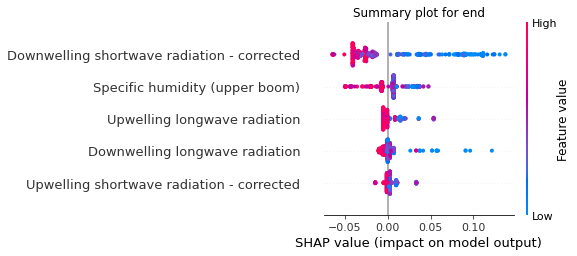

In [56]:
# Loop through each class
for class_name, class_label in label_dict_sorted.items():

    # Calculate SHAP values for the current class
    shap_values = shap.TreeExplainer(model).shap_values(X_test)
    shap_values_class = shap_values[class_label]

    # Calculate absolute SHAP values for each feature
    shap_df = pd.DataFrame(abs(shap_values_class), columns=X_test.columns)

    # Get top 5 features for the current class
    top_features = shap_df.mean().sort_values(ascending=False)[:5]

    # Create a table with top 5 features and their corresponding SHAP values for the current class
    top_features_table = pd.DataFrame({'Feature': top_features.index,
                                       'SHAP Value': top_features.values})

    # Add a column with the class name
    #top_features_table['Class'] = class_name

    # Print the table for the current class
    print(f'{class_name}:')
    
    print("Accuracy:" , eval(f"accuracy_{class_name}"))
    print("F1:" , eval(f"f1_{class_name}"))
    
    display(top_features_table)

    # Create summary plot for the current class
    shap.summary_plot(shap_values_class, X_test, plot_type="dot", color='coolwarm', max_display=5, show=False)
    plt.title(f'Summary plot for {class_name}')
    plt.show()

--------